In [ ]:
"""
A bare bones examples of optimizing a black-box function (f) using
Natural Evolution Strategies (NES), where the parameter distribution is a 
gaussian of fixed standard deviation.
"""

import numpy as np
np.random.seed(0)

# the function we want to optimize
def f(w):
    # here we would normally:
    # ... 1) create a neural network with weights w
    # ... 2) run the neural network on the environment for some time
    # ... 3) sum up and return the total reward

    # but for the purposes of an example, lets try to minimize
    # the L2 distance to a specific solution vector. So the highest reward
    # we can achieve is 0, when the vector w is exactly equal to solution
    reward = -np.sum(np.square(solution - w))
    return reward

In [ ]:
# hyperparameters
npop = 50 # population size
sigma = 0.1 # noise standard deviation
alpha = 0.001 # learning rate

In [ ]:
# start the optimization
solution = np.array([0.5, 0.1, -0.3])
w = np.random.randn(3) # our initial guess is random
for i in range(300):

    # print current fitness of the most likely parameter setting
    if i % 20 == 0:
        print('iter %d. w: %s, solution: %s, reward: %f' % 
              (i, str(w), str(solution), f(w)))

    # initialize memory for a population of w's, and their rewards
    N = np.random.randn(npop, 3) # samples from a normal distribution N(0,1)
    R = np.zeros(npop)
    for j in range(npop):
        w_try = w + sigma*N[j] # jitter w using gaussian of sigma 0.1
        R[j] = f(w_try) # evaluate the jittered version

    # standardize the rewards to have a gaussian distribution
    A = (R - np.mean(R)) / np.std(R)
    # perform the parameter update. The matrix multiply below
    # is just an efficient way to sum up all the rows of the noise matrix N,
    # where each row N[j] is weighted by A[j]
    w = w + alpha/(npop*sigma) * np.dot(N.T, A)


### 1. Import the Necessary Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


### 2. Instantiate the Environment and Agent

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)
print("weight dim.:",agent.get_weights_dim())

observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
  - low: [-1.]
  - high: [1.]
weight dim.: 65


### 3. Train the Agent with the Cross-Entropy Method

Episode 10	Average Score: -74.57
Episode 20	Average Score: -74.34
Episode 30	Average Score: -74.11
Episode 40	Average Score: -73.91
Episode 50	Average Score: -73.64
Episode 60	Average Score: -73.10
Episode 70	Average Score: -72.58
Episode 80	Average Score: -71.94
Episode 90	Average Score: -71.28
Episode 100	Average Score: -70.66
Episode 110	Average Score: -70.05
Episode 120	Average Score: -69.41
Episode 130	Average Score: -68.87
Episode 140	Average Score: -68.31
Episode 150	Average Score: -67.70
Episode 160	Average Score: -67.10
Episode 170	Average Score: -66.43
Episode 180	Average Score: -65.72
Episode 190	Average Score: -65.02
Episode 200	Average Score: -64.35
Episode 210	Average Score: -63.71
Episode 220	Average Score: -63.05
Episode 230	Average Score: -62.36
Episode 240	Average Score: -61.69
Episode 250	Average Score: -60.99
Episode 260	Average Score: -60.28
Episode 270	Average Score: -59.59
Episode 280	Average Score: -58.94
Episode 290	Average Score: -58.27
Episode 300	Average Sco

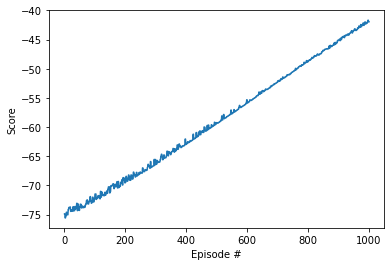

In [5]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=200, elite_frac=0.2, alpha=0.001, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        alpha (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    #n_elite=int(pop_size*elite_frac)
    #npop = 500 # population size
    #sigma = 0.1 # noise standard deviation
    #alpha = 0.001 # learning rate
    
    n_elite=int(pop_size*elite_frac)
    
    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma*np.random.randn(agent.get_weights_dim())
    #w = np.random.randn(agent.get_weights_dim())
    
    for i_iteration in range(1, n_iterations+1):
        
        #######################################################

#         N = np.random.randn(npop, agent.get_weights_dim())
#         R = np.zeros(npop)
        
#         for j in range(npop):
#             w_try = w + sigma*N[j] # jitter w using gaussian of sigma 0.1
#             R[j] = agent.evaluate(w_try, gamma, max_t) # evaluate the jittered version

#         # standardize the rewards to have a gaussian distribution
#         A = (R - np.mean(R)) / np.std(R)
#         # perform the parameter update. The matrix multiply below
#         # is just an efficient way to sum up all the rows of the noise matrix N,
#         # where each row N[j] is weighted by A[j]
#         w = w + alpha/(npop*sigma) * np.dot(N.T, A)

#         reward = agent.evaluate(w, gamma=1.0)
        
        #######################################################
        
        weights_pop = np.array([best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)])
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        #elite_idxs = rewards.argsort()[-n_elite:]
        #elite_weights = [weights_pop[i] for i in elite_idxs]
        #best_weight = np.array(elite_weights).mean(axis=0)
        
        advantage = (rewards- np.mean(rewards)) / np.std(rewards)
        best_weight = best_weight + alpha/(pop_size*sigma) * np.dot(weights_pop.T, advantage)
        
        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        ################
        
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

In [ ]:
env.close()

https://rfriend.tistory.com/549


In [ ]:
import numpy as np
arr = np.array([1,3,5,4])
arr.argsort()

In [ ]:
arr = np.array([[1,3,5,4],
                [1,1,1,1]])
arr.mean(axis=0)

In [ ]:
arr = np.array([1,3,5,4])
arr[:, None]

In [ ]:
arr = np.array([[1,3,5,4],
                [1,1,1,1]])
brr = np.array([1,2])
brr = brr[:, None]
crr = arr*brr
print(crr)
crr.sum(axis=0)